In [1]:
import numpy as np
import pandas as pd
import rasterio  # 导入rasterio
import os
import cv2
from sklearn.preprocessing import StandardScaler

# 设置路径
precipitation_folder = "/data/2008-2018_preciption/"  # 降水量图文件夹
NDVI_folder = "/data/NDVI_2008-2018/"  #NDVI图
o3_folder = "/data/o3_2008-2018/"       #臭氧图
crop_data_path = "/data/grain_data_2008_2018.csv"  # 粮食产量数据文件

#co2_folder = "/data/co2_2008-2018/"     #co2图
#temperature_folder = "/data/2008-2018_temperature/"  # 气温图文件夹

# 读取粮食产量数据
crop_data = pd.read_csv(crop_data_path)
years = crop_data['year'].values
yields = crop_data['yield'].values

# 读取并处理卫星遥感图像
def load_and_preprocess_images(precipitation_folder,NDVI_folder,o3_folder, years):# temperature_folder,NDVI_folder,co2_folder,o3_folder, temperature_folder  co2_folder
    images = []
    for year in years:
        # 使用rasterio打开各类卫星图像
        precip_image_path = os.path.join(precipitation_folder, f"SUM_{year}.tif")
        with rasterio.open(precip_image_path) as src:
            precip_image = src.read(1)  # 读取第一个波段

        NDVI_image_path = os.path.join(NDVI_folder, f"MEAN_{year}.tif")
        with rasterio.open(NDVI_image_path) as src:
            NDVI_image = src.read(1) 
        
        


        o3_image_path = os.path.join(o3_folder, f"{year}.tif")
        with rasterio.open(o3_image_path) as src:
            o3_image = src.read(1) 
            
        # temp_image_path = os.path.join(temperature_folder, f"MEAN_{year}.tif")
        # with rasterio.open(temp_image_path) as src:
        #     temp_image = src.read(1) 
        
        # co2_image_path = os.path.join(co2_folder, f"v8.0_FT2022_GHG_CO2_{year}_TOTALS_emi.tif")
        # with rasterio.open(co2_image_path) as src:
        #     co2_image = src.read(1)  

        # 调整图像大小为较低分辨率（如256x256）以节省内存 1024  1920,1080
        precip_image = cv2.resize(precip_image, (1080, 720), interpolation=cv2.INTER_LINEAR)
        NDVI_image = cv2.resize(NDVI_image,(1080, 720), interpolation=cv2.INTER_LINEAR)
        o3_image = cv2.resize(o3_image,(1080, 720), interpolation=cv2.INTER_LINEAR)
        
        # 归一化图像并确保数据类型为float32
        precip_image = precip_image.astype(np.float32)  # 转换为 float32
        NDVI_image = NDVI_image.astype(np.float32)
        o3_image = o3_image.astype(np.float32) 

        precip_image = precip_image / precip_image.max()  # 归一化到 0-1 范围
        NDVI_image = NDVI_image / NDVI_image.max()
        o3_image = o3_image / o3_image.max()
        
        # # 归一化图像
        precip_image = precip_image*10
        NDVI_image = NDVI_image*10
        o3_image = o3_image*10
        
        # 将两个图像堆叠成一个4D图像（4通道，降水量+NDVI+臭氧）
        combined_image = np.stack([precip_image,NDVI_image,o3_image], axis=-1)#, temp_image temp_image,co2_image,

        images.append(combined_image)

    return np.array(images)




In [2]:
import tensorflow as tf
tf.keras.backend.clear_session()  # 清理 TensorFlow 会话

2024-12-26 19:42:25.486427: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-26 19:42:26.587062: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
print(yields)

[64983.97 65789.22 66160.73 66043.51 66060.27 63964.83 63048.2  61222.62
 58849.33 55911.31 53940.86]


In [4]:
# 使用rasterio读取图像并预处理
X = load_and_preprocess_images(precipitation_folder,NDVI_folder,o3_folder, years = range(2008, 2019))#temperature_folder, co2_folder,
# temperature_folder,co2_folder,


In [5]:
from sklearn.preprocessing import MinMaxScaler
#标准化产量数据
scaler = MinMaxScaler()
Y = scaler.fit_transform(yields.reshape(-1, 1))
# Y = yields.reshape(-1,1)

# 将X和Y的数据形状调整为适合CNN-LSTM模型的输入
X = X.reshape((X.shape[0], X.shape[1], X.shape[2], X.shape[3]))  # 样本数, 高, 宽, 通道数
# Y = Y.reshape(-1, 1)

X.shape
Y.shape

(11, 1)

In [6]:
X.shape

(11, 720, 1080, 3)

In [7]:
Y.shape

(11, 1)

In [8]:
print(Y)

[[0.9037011 ]
 [0.96959788]
 [1.        ]
 [0.99040743]
 [0.99177896]
 [0.82030087]
 [0.74528943]
 [0.59589505]
 [0.4016794 ]
 [0.16124967]
 [0.        ]]


In [9]:
# 检查输入数据是否包含 NaN 或 Inf
if np.any(np.isnan(X)) or np.any(np.isinf(X)):
    print("训练数据中包含 NaN 或 Inf")

训练数据中包含 NaN 或 Inf


In [10]:
if np.any(np.isnan(X)):
    print("训练数据中包含 NaN 或 Inf")

训练数据中包含 NaN 或 Inf


In [11]:
if np.any(np.isnan(Y)):
    print("训练数据中包含 NaN 或 Inf")

In [12]:
import numpy as np

# X = np.array(...)

# 1. 识别 NaN 和 Inf
nan_mask = np.isnan(X)
inf_mask = np.isinf(X)

# 2. 计算均值，忽略 NaN 值
mean_value = np.nanmean(X)

# 3. 用均值填充 NaN 和 Inf
X[nan_mask] = mean_value
X[inf_mask] = mean_value

# 现在 X 中的 NaN 和 Inf 已被均值替换


In [13]:
if np.any(np.isnan(X)):
    print("训练数据中包含 NaN 或 Inf")

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Reshape
import tensorflow as tf
import matplotlib.pyplot as plt


# 1. 定义两个模型函数
def build_model_CNN_LSTM(input_shape, optimizer):
    model = Sequential()

    # CNN部分
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # 展平
    model.add(Flatten())

    # LSTM部分
    model.add(Reshape((-1,128)))
    model.add(LSTM(50, activation='tanh', return_sequences=False))

    # 全连接层
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))

    # 输出层
    model.add(Dense(1))  # 预测粮食产量

    # 编译模型
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model





In [15]:
def build_model_CNN(input_shape, optimizer):
    model = Sequential()

    # CNN部分
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # 展平
    model.add(Flatten())

    # 全连接层
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))

    # 输出层
    model.add(Dense(1))  # 预测粮食产量

    # 编译模型
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [16]:
# import tensorflow as tf
# tf.keras.backend.clear_session()  # 清理 TensorFlow 会话


In [17]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# 定义输入形状：256x256图像，2通道（降水量+气温）
input_shape = (1080,720, 3)

# 划分训练集和验证集
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# 2. 使用CNN模型
adam_optimizer = Adam(learning_rate=0.00001)
model_adam = build_model_CNN(input_shape, adam_optimizer)

history_adam = model_adam.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=70, batch_size=8)

# # 保存模型
# model.save('cnn_model.h5')


2024-12-26 19:42:51.211635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14416 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:0a:00.0, compute capability: 8.9
/data/miniconda/envs/torch/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/70


I0000 00:00:1735213375.085211   56790 service.cc:145] XLA service 0x7f6c2400c8d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735213375.085257   56790 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-12-26 19:42:55.147651: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-26 19:42:55.424667: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900
I0000 00:00:1735213402.960252   56790 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step - loss: 1.1495 - mae: 1.0235 - val_loss: 271.4740 - val_mae: 16.4731
Epoch 2/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - loss: 201.8629 - mae: 13.8713 - val_loss: 26.8759 - val_mae: 5.1735
Epoch 3/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - loss: 30.3289 - mae: 5.4488 - val_loss: 0.5052 - val_mae: 0.6284
Epoch 4/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - loss: 0.6221 - mae: 0.7118 - val_loss: 0.5052 - val_mae: 0.6284
Epoch 5/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - loss: 0.6221 - mae: 0.7118 - val_loss: 0.5052 - val_mae: 0.6284
Epoch 6/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - loss: 0.6221 - mae: 0.7118 - val_loss: 0.5052 - val_mae: 0.6284
Epoch 7/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - loss: 0.6221 - mae: 0.7118 - val_loss: 0.5052 - val_mae: 0.6284
Epoch 8/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - loss: 0.6221 - mae: 0.7119 - val_loss: 0.5052 - val_mae: 0.6284
Epoch 9/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - loss: 0.6221 - mae: 0.71

In [18]:
# 3. 使用CNN_LSTM模型
sgd_optimizer = Adam(learning_rate=0.00001)
model_sgd = build_model_CNN_LSTM(input_shape, sgd_optimizer)

history_sgd = model_sgd.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=70, batch_size=8)

# # 保存模型
# model.save('cnn_lstm_model.h5')


Epoch 1/70


2024-12-26 19:44:04.952791: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.93GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - loss: 0.7127 - mae: 0.7711 - val_loss: 0.5619 - val_mae: 0.6720
Epoch 2/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.7217 - mae: 0.7799 - val_loss: 0.5452 - val_mae: 0.6595
Epoch 3/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6880 - mae: 0.7529 - val_loss: 0.5281 - val_mae: 0.6464
Epoch 4/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.7122 - mae: 0.7672 - val_loss: 0.5094 - val_mae: 0.6317
Epoch 5/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5915 - mae: 0.6915 - val_loss: 0.4918 - val_mae: 0.6177
Epoch 6/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5995 - mae: 0.6970 - val_loss: 0.4736 - val_mae: 0.6027
Epoch 7/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5337 - mae: 0.6497 - val_loss: 0.4554 - val_mae: 0.5875
Epoch 8/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5686 - mae: 0.6914 - val_loss: 0.4375 - val_mae: 0.5721
Epoch 9/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5310 - mae: 0.6722 - val_loss: 0.4206 - val_mae:

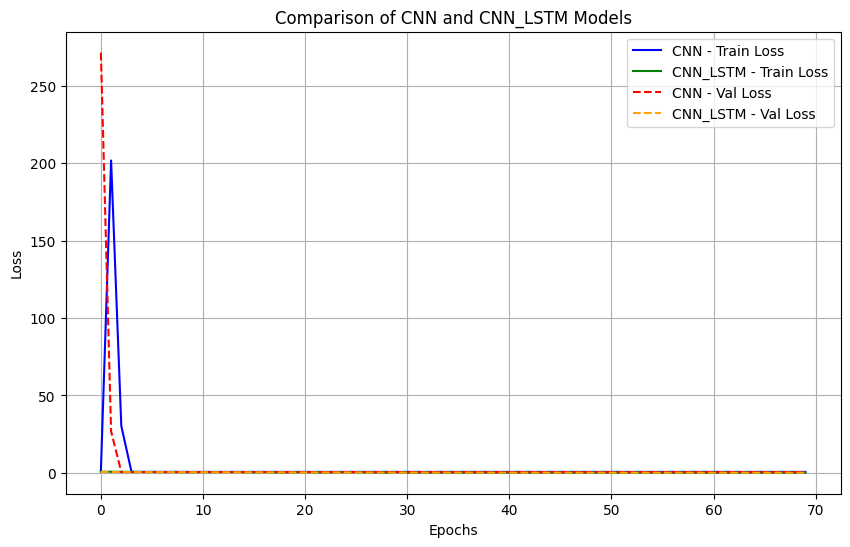

In [19]:
# 4. 绘制训练损失曲线
plt.figure(figsize=(10, 6))

# Adam优化器的训练损失
plt.plot(history_adam.history['loss'], label='CNN - Train Loss', color='blue')

# SGD优化器的训练损失
plt.plot(history_sgd.history['loss'], label='CNN_LSTM - Train Loss', color='green')

# Adam优化器的验证损失
plt.plot(history_adam.history['val_loss'], label='CNN - Val Loss', color='red', linestyle='--')

# SGD优化器的验证损失
plt.plot(history_sgd.history['val_loss'], label='CNN_LSTM - Val Loss', color='orange', linestyle='--')

plt.title('Comparison of CNN and CNN_LSTM Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

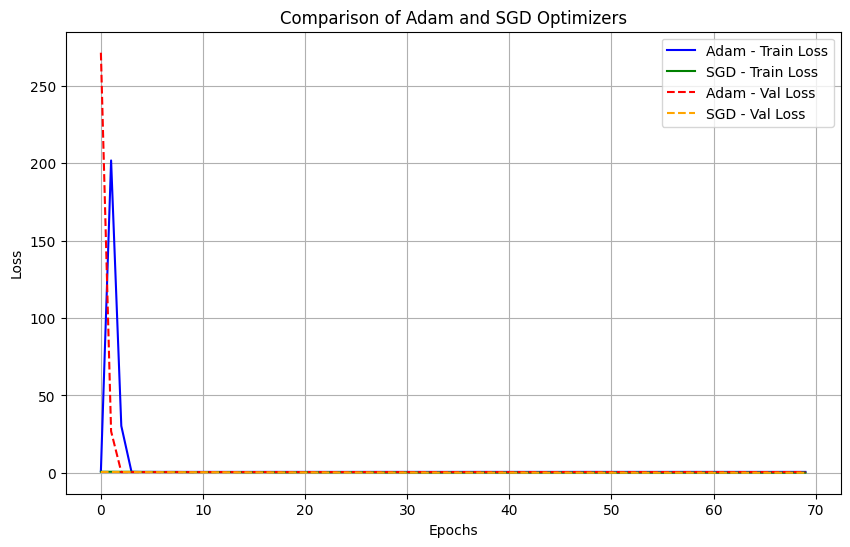

In [20]:
# 4. 绘制训练损失曲线
plt.figure(figsize=(10, 6))

# Adam优化器的训练损失
plt.plot(history_adam.history['loss'], label='Adam - Train Loss', color='blue')

# SGD优化器的训练损失
plt.plot(history_sgd.history['loss'], label='SGD - Train Loss', color='green')

# Adam优化器的验证损失
plt.plot(history_adam.history['val_loss'], label='Adam - Val Loss', color='red', linestyle='--')

# SGD优化器的验证损失
plt.plot(history_sgd.history['val_loss'], label='SGD - Val Loss', color='orange', linestyle='--')

plt.title('Comparison of Adam and SGD Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

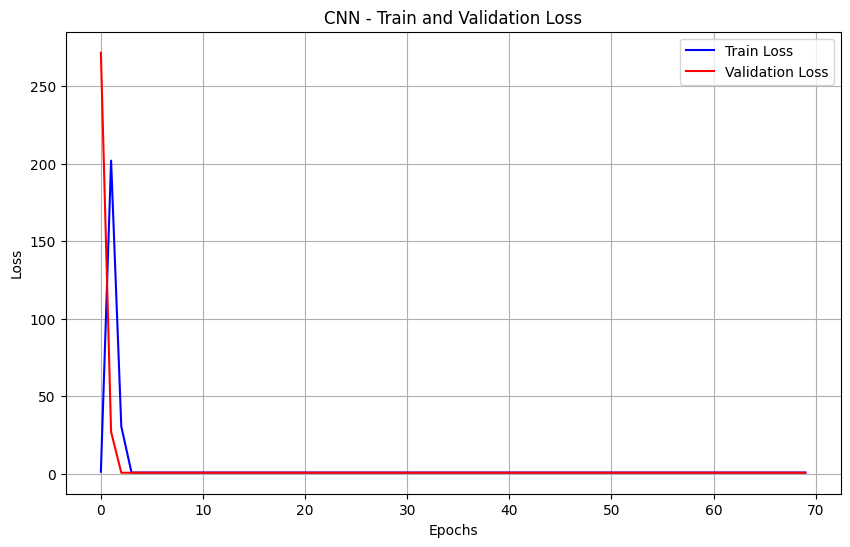

In [21]:
# 绘制损失曲线
import matplotlib.pyplot as plt

# 获取训练过程中的损失数据
train_loss = history_adam.history['loss']
val_loss = history_adam.history['val_loss']

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('CNN - Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

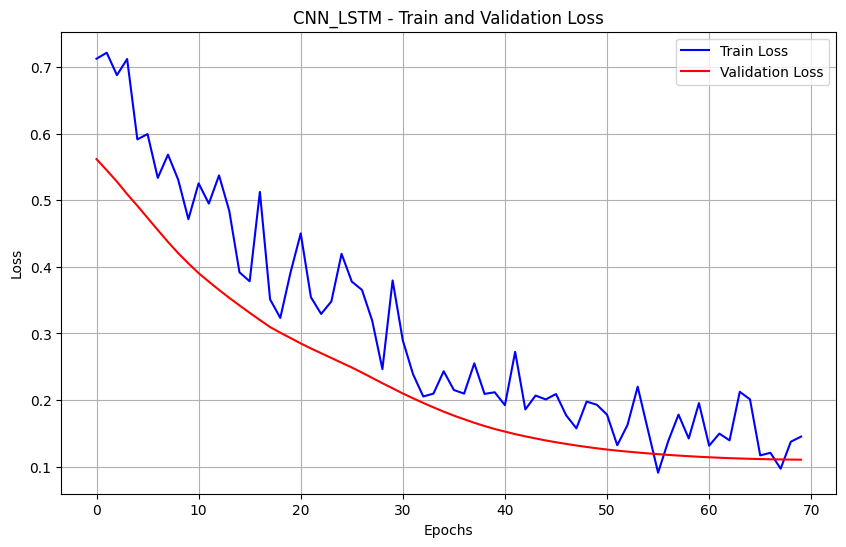

In [22]:
# 绘制损失曲线
import matplotlib.pyplot as plt

# 获取训练过程中的损失数据
train_loss = history_sgd.history['loss']
val_loss = history_sgd.history['val_loss']

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('CNN_LSTM - Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# # 预测
# predictions = model.predict(X_val)

# # # 逆标准化预测值
# # predictions = scaler.inverse_transform(predictions)
# print(predictions)
# print(Y_val)


In [24]:
# # 评估模型
# from sklearn.metrics import mean_squared_error
# mse = mean_squared_error(scaler.inverse_transform(Y_val), predictions)

# print(f'Mean Squared Error: {mse}')